# Project 2b - Projectile Motion : Improved Integrators and a unified interface

## Due 2/9

We have now seen a few different versions of the particle motion problem: one for 1D motion without drag, one for 1D motion with drag, and then an extension to 2D motion with drag.  All of these equations have something in common, which is that they can be written in the form
$$
\frac{d \mathbf{u}}{d t} = \mathcal{F}(t,\mathbf{u})
$$
with $\mathbf{u}$ being a vector of state variables (for example, position and velocity in one or two or more directions), and $\mathcal{F}$ representing the right hand sides of the equations of motion.  For example in 2D drag, we might write
$$
\mathbf{u} = \left[\matrix{x \\ v_x \\ z \\ v_z}\right]
$$
and 
$$
\mathcal{F}(t,\mathbf{u}) = \left[\matrix{v_x \\ 
                                        -\frac{c_d}{m} \sqrt{v_x^2 + v_z^2} \;v_x  \\
                                        v_z \\
                                        g -\frac{c_d}{m} \sqrt{v_x^2 + v_z^2} \;v_z}\right].
$$
Indeed, many important scenarios that we may wish to model, ranging from Newtonian physics to population dynamics and beyond fall within this framework.  Because we will be modelling many such systems, it will be helpful to develop a convenient framework for operating on such systems.  In particular, we would like to develop an object oriented framework for working with these problems so that we can reuse as much code as possible (while also keeping our code nice).  We will continue to modify these methods as we require additional functionality, but these will form a good start.  

### A class for problem specification
Our first task will be to create a python class representing our problem.  This doesn't really need to do much: all it really needs to return is the function $\mathcal{F}(t,\mathbf{u})$ and to store any information relevant to the class.  As an example, I've provided a class for the drag-free 1D particle motion equation.  **Create a new class using the existing one as a template that implements the 2D equations with drag.**  

In [1]:
import numpy as np


class ParticleMotion1D:
    """ This is an example class for an ODE specification"""
    
    def __init__(self,g=-9.81):
        
        self.n_dof = 2
        self.g = g
        
    def rhs(self,t,u):
        # the right hand side of the ode (or $\mathcal{F}(t,u)$)
        dudt = np.zeros(self.n_dof)
        dudt[0] = u[1]
        dudt[1] = self.g
        return dudt
    
class ParticleMotion2DWithDrag:
    
    # Do you need other keyword arguments here?
    def __init__(self,g=-9.81, c = 0, m = 1):
        self.n_dof = 4
        self.g = g
        self.c = c
        self.m = m

    
    def rhs(self,t,u):
        dudt = np.zeros(self.n_dof)
        dudt[0] = u[1]
        dudt[1] = (-self.c/self.m)*(u[1]/np.sqrt(u[1]**2+u[3]**2))*u[1]
        dudt[2] = u[3]
        dudt[3] = self.g + (-self.c/self.m)*(u[3]/np.sqrt(u[1]**2+u[3]**2))*u[3]

        return dudt
    

### A class for time stepping
We will also be utilizing multiple different methods for performing numerical integration.  One simple choice is Euler's method.  A reasonable class for doing this might be



In [2]:
class Euler:
    def __init__(self):
        pass   
    
    def step(self,ode,t,dt,u_0):
        u_1 = u_0 + dt*ode.rhs(t,u_0)
        return u_1

Note that there is no reference to particle motion or to any other particular problem specifically: all this requires is the current time, the desired time step, the initial state, and the object representing the problem.  Thus, one could easily use either my implementation of the simple 1D particle or your implementation of the 2D particle *with no modification to the code* (assuming that shapes are all correct, which is something one might wish to check).  This modularity is, obviously, highly desirable.  We can also view this class as a template for more performant time-stepping schemes such as the midpoint method or Runge-Kutta 4.  The midpoint method (or RK2) is defined as 
$$
\mathbf{u}_{n+1} = \mathbf{u}_n + \frac{\Delta t}{2}(k_1 + k_2)
$$
$$
k_1 = \mathcal{F}(t,\mathbf{u}_n)
$$
$$
k_2 = \mathcal{F}(t + \frac{\Delta t}{1}, \mathbf{u}_n + \frac{\Delta t}{1} k_1)
$$
**Adapt the above class to implement RK2**



In [3]:
class RK2:
    def __init__(self):
        pass   
    
    def step(self,ode,t,dt,u_0):
        # Do some stuff here
        k1 = ode.rhs(t, u_0)
        k2 = ode.rhs(t + dt, u_0 + dt*k1)
        return u_0 + (dt/2)*(k1 + k2)

**Also implement RK4** (Gould Eqs. 3.59, 3.60)

In [4]:
class RK4:
    def __init__(self):
        pass   
    
    def step(self,ode,t,dt,u_0):
        k1 = ode.rhs(t, u_0)*dt
        k2 = ode.rhs(t + dt/2, u_0 + k1/2)*dt
        k3 = ode.rhs(t+ dt/2, u_0 + k2/2)*dt
        k4 = ode.rhs(t + dt, u_0 + k3)*dt
        return u_0 + 1/6*(k1 + 2*k2 + 2*k3 + k4)

Finally, the typical use case for these objects is to perform an integration over multiple time steps, and its nice to contain such operations in a class.  A reasonable implementation of such a thing might look like:

In [5]:
class Integrator:
    def __init__(self,ode,method):
        self.ode = ode #specifies 1d or 2d
        self.method = method #euler, rk2, rk4
        
    def integrate(self,interval,dt,u_0):
        t_0 = interval[0] 
        t_end = interval[1]
        
        times = [t_0]
        states = [u_0]
        
        t = t_0
        while t<t_end:
            dt_ = min(dt,t_end-t) #picks the smallest of dt and interval length
            u_1 = self.method.step(self.ode,t,dt_,u_0) #gets next position
            t = t + dt_ #increases time interval by dt
            u_0 = u_1 #old position is now new position
            
            times.append(t)
            states.append(u_1)
            
        return np.array(times),np.array(states)

No modifications to the above code are needed at this stage, but I would like you to **go through it, line by line, and add comments describing what all of the elements are doing**.  This should be straightforward, as I hope that it looks very much like some code that you've already written.  

An example of all of these components working together is

In [6]:
import matplotlib.pyplot as plt

pm = ParticleMotion1D()
method = Euler()
integrator = Integrator(pm,method)

t_0 = 0.0
t_end = 1.0
dt = 0.01
z_0 = 5.0
v_0 = 5.0
t,u = integrator.integrate([t_0,t_end],dt,np.array([z_0,v_0]))

plt.plot(t,u[:,0])

**Verify your implementations by testing similar code to the above block with all different combinations of problems and time stepping schemes.**  Note that if your improved time-stepping schemes are working, a particle integrated using RK2 or RK4 with relatively large time steps (say $\Delta t=0.1$ should end up in a very similar place to one integrated with Euler's method with a very small time step (which is implemented correctly) (say $\Delta t=.001$).

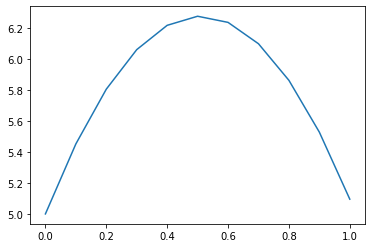

In [7]:
pm = ParticleMotion1D()
method = RK2()
integrator = Integrator(pm,method)

t_0 = 0.0
t_end = 1.0
dt = 0.1
z_0 = 5.0
v_0 = 5.0
t,u = integrator.integrate([t_0,t_end],dt,np.array([z_0,v_0]))

plt.plot(t,u[:,0])

In [8]:
u.shape # x, vx, z, vz

(12, 2)

(-2.729200133868088,
 57.31320281122984,
 -12.018734230097646,
 11.048511153814173)

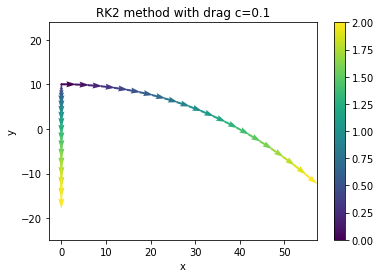

In [43]:
pm = ParticleMotion2DWithDrag(c=.1)
method = RK2()
integrator = Integrator(pm,method)

t_0 = 0.0
t_end = 2.0
dt = 0.1
z_0 = 5.0
vz_0 = 5.0
x_0 = 0.0
vx_0 = 5.0
t,u = integrator.integrate([t_0,t_end],dt,np.array([0, 0, 10, 0.01])) # x, vx, y, vy
t2,u2 = integrator.integrate([t_0,t_end],dt,np.array([0, 30, 10, 0.01])) # x, vx, y, vy
fig,ax = plt.subplots()
c = ax.quiver(u[:,0], u[:,2], u[:,1], u[:,3], t)
c2 = ax.quiver(u2[:,0], u2[:,2], u2[:,1], u2[:,3], t2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('RK2 method with drag c=0.1')
plt.colorbar(c)
plt.axis('equal')

(4.792804953130473, 9.35109598426007, -0.06977051044169234, 1.4651807192755393)

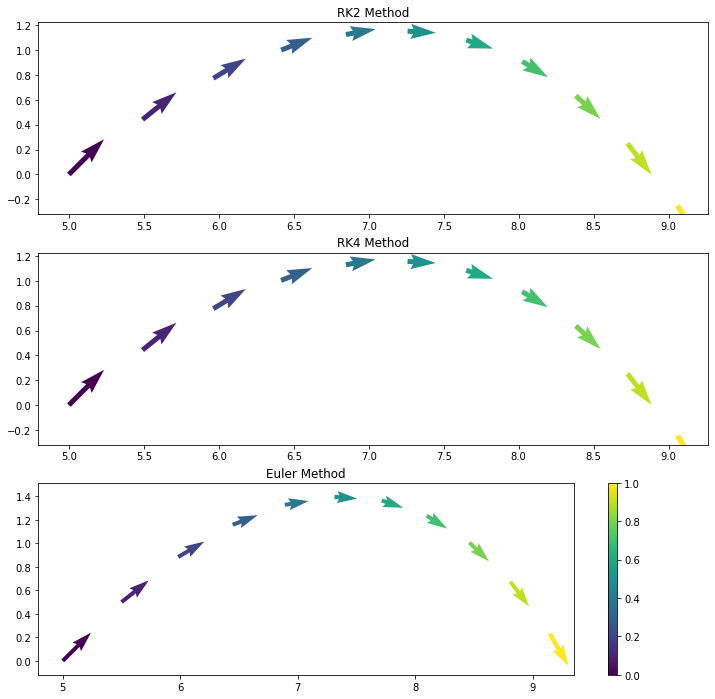

In [12]:
pm = ParticleMotion2DWithDrag(c=.5)


t_0 = 0.0
t_end = 1.0
dt = 0.1
z_0 = 5.0
vz_0 = 5.0
x_0 = 0.0
vx_0 = 5.0

# rk2
method = RK2()
integrator = Integrator(pm,method)
t,u = integrator.integrate([t_0,t_end],dt,np.array([z_0, vz_0, x_0, vx_0]))

# rk4
method = RK4()
integrator = Integrator(pm,method)
t,u2 = integrator.integrate([t_0,t_end],dt,np.array([z_0, vz_0, x_0, vx_0]))

# euler
method = Euler()
integrator = Integrator(pm,method)
t,u3 = integrator.integrate([t_0,t_end],dt,np.array([z_0, vz_0, x_0, vx_0]))

fig,ax = plt.subplots(3, figsize=(12,12))
b = ax[0].quiver(u[:,0], u[:,2], u[:,1], u[:,3], t)
c = ax[1].quiver(u2[:,0], u2[:,2], u2[:,1], u2[:,3], t)
d = ax[2].quiver(u3[:,0], u3[:,2], u3[:,1], u3[:,3], t)
ax[0].set_title('RK2 Method')
ax[1].set_title('RK4 Method')
ax[2].set_title('Euler Method')
plt.colorbar(c)
plt.axis('equal')
